In [1]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colorbar as mbar

from scipy.ndimage import gaussian_filter as smooth
from sklearn.preprocessing import StandardScaler as Scaler

import statsmodels.api as sm

from scipy.stats import mannwhitneyu as mnu
from scipy.stats import permutation_test

from sklearn.metrics.pairwise import cosine_similarity as cosine
from scipy.stats import pearsonr as pearson
from scipy.stats import spearmanr as spearman
from scipy.stats import kendalltau as kendall

from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

# Definitions

In [2]:
def movavg(input, win=[], step=[]):
    '''
    Args:
        input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        win:   size of the window for moving averge
        step:  step size for moving forward
    Returns:
        output:     matrix of output data, with shape (Neurons,Stimuli,Timepoints),
                    where Timepoints are following the moving average process
        timestamps: (N,) vector of timepoints, corresponding to the output data, 
                    where N is the number of timepoints following the moving average process
    '''

    if not win: win = input.shape[2] // 25
    if not step: step = win // 10
    
    bins = [np.arange(0,input.shape[2]-win+1,step), 
            np.arange(win, input.shape[2]+1, step)]
    
    nbins = np.array(bins).shape[1]
    output = np.nan * np.zeros((input.shape[0], input.shape[1], nbins))

    timestamps = []
    counter_bin = 0
    for bin_st, bin_end in tqdm(zip(bins[0],bins[1])):
        timestamps.append(np.nanmean([bin_st, bin_end]))
        output[:,:,counter_bin] = np.nanmean(input[:,:,bin_st:bin_end], axis=2)
        counter_bin += 1

    return output, np.array(timestamps)


def categorizer(data_sample):
    if data_sample['defi']=='face_human':
        cat_num = 0
    elif data_sample['defi']=='face_monkey':
        cat_num = 1
    elif data_sample['defi']=='body_monkey':
        cat_num = 2
    elif data_sample['defi']=='body_human':
        cat_num = 3
    elif data_sample['defi']=='animal':
        cat_num = 4
    elif data_sample['defi']=='reptile':
        cat_num = 5
    elif data_sample['defi']=='fish':
        cat_num = 6
    elif data_sample['defi']=='bird':
        cat_num = 7
    elif data_sample['defi']=='insect':
        cat_num = 8
    elif data_sample['defi']=='plant':
        cat_num = 9
    elif data_sample['defi']=='fruit':
        cat_num = 10
    elif data_sample['defi']=='chair':
        cat_num = 11
    elif data_sample['defi']=='car':
        cat_num = 12
    elif data_sample['defi']=='house':
        cat_num = 13
    elif data_sample['defi']=='clock':
        cat_num = 14
    elif data_sample['defi']=='tool':
        cat_num = 15
    return cat_num


def m_plot(input_data, colors, error_method='sem', smooth_win=0, labels=[], plot_title='', timepoints=[], figure_size=(8,3)):
    '''
    Args:
        input_data:   (N,M,T) matrix of input data, (Conditions,Samples,Timepoints)
        colors:       (N,4) matrix of colors for the generated plots in [R,G,B,FaceAlpha] format,
                      where N is the number of conditions. FaceAlpha in the scale=[0-255]
        error_method: variation metric ('sem' & 'std')
        smooth_win:   smoothing window
        
        labels:       (N,) list of labels for the generated plots, where N is the number of conditions
        plot_title:   title of the generated plot
        timepoints:   (N,) vaetor of timepoints
        figure_size:  two-item tuple containing width and height of the figure
    Returns:
        none
    '''

    colors = np.array(colors) / np.array(255)
    if not labels: labels=['']*len(input_data)
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,input_data[0].shape[1])
    
    plt.figure(figsize=figure_size)
    # sns.set_style('darkgrid')
    for i,Cond in enumerate(input_data):
        data_ave = smooth(np.nanmean(Cond, axis=0), smooth_win, axes=0)
        data_std = smooth(np.nanstd(Cond, axis=0), smooth_win, axes=0)
        
        if error_method=='sem':
            error_up  = data_ave + (data_std / np.sqrt(Cond.shape[0]))
            error_low = data_ave - (data_std / np.sqrt(Cond.shape[0]))
        elif error_method=='std':
            error_up  = data_ave + data_std
            error_low = data_ave - data_std

        plt.fill_between(timepoints, error_up, error_low, color=colors[i], label='_nolegend_')
        plt.plot(timepoints, data_ave, color=colors[i,:3], lw=3, label=labels[i])
    
    ylim = plt.ylim()
    plt.fill_between([0, 80], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.2, edgecolor=None)
    plt.legend(frameon=False, fontsize=10)
    plt.title(plot_title)
    plt.tight_layout()


def plot_repmat(input_repmat, plot_sz=3, show_clb=False, titles=[], colormap='coolwarm', cbar_label='Cosine Similarity (au)', fig_title=''):
    '''
    Args:
        input_repmat: (M,N,N) representatational matrices, where M is the number of conditions and
                      N is the total number of samples
        plot_sz:      size of the generated plot
        show_clb:     if True, colorbar will be shown
        titles:       list of titles of each representatational matrix
        colormap:     colormap for the generated plot
        cbar_label:   colorbar label
    Returns:
        none
    '''

    if not titles: titles=['']*len(input_repmat)
    if show_clb==True:
        fig, axs = plt.subplots(nrows=1, ncols=len(input_repmat)+1, figsize=(3*plot_sz,plot_sz),  dpi=500)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=len(input_repmat), figsize=(3*plot_sz,plot_sz),  dpi=500)

    for ax,repmat,tle in zip(axs.flatten(), input_repmat, titles):
        ax.imshow(repmat, cmap=colormap)
        ax.set_title(tle, fontsize=plot_sz*5)
        ax.axis('off')
    if show_clb:
        clb = mbar.ColorbarBase(ax=axs[-1], cmap=colormap, orientation="vertical", ticks=[0,1])
        clb.set_label(cbar_label, fontsize=plot_sz*3)
        clb.outline.set_visible(False)
    plt.suptitle(fig_title, fontsize=plot_sz*10)


def mk_repmat_kernel(input_ls, plot_kernel=False):
    '''
    Args:
        input_ls:    list with the number of samples per condition, i.e., 
                     the list size is the number of categories
        plot_kernel: if True, the created kernel will be plotted
    Returns:
        kernel: (N,N) theoretical ground-truth representatational matrix,
                where N is the total number of samples
    '''

    kernel = np.zeros([sum(input_ls),sum(input_ls)])
    counter_ind = 0
    for i in input_ls:
        inds = np.arange(counter_ind, counter_ind+i)
        counter_ind += i
        kernel[np.ix_(inds,inds)] = 1
        
    if plot_kernel:
        plt.figure(figsize=(2,2))
        plt.imshow(kernel, cmap='coolwarm')
        plt.axis('off')

    return kernel


def mk_repmat_data(input_data, sim_method='cosine', print_info=False):
    '''
    Args:
        input_data: matrix of input data, with shape (Neurons,Stimuli)
        sim_method: method for creating representatational matrix
                    cosine, for cosine similarity
                    spearman, for spearman correlation 
        print_info: if True, the progression will be printed
    Returns:
        repmat: (N,N) representatational matrix, where N is the total number of samples
    '''

    if sim_method=='cosine':
        repmat = cosine(input_data.T)
    elif sim_method=='spearman':
        CorRows = []
        for stim_i in range(input_data.shape[1]):
            CorCols = []
            for stim_j in range(input_data.shape[1]):
                CorCols.append(spearman(input_data[:,stim_i], input_data[:,stim_j])[0])

                if print_info:
                    print('stim_i: ' + str(((stim_i+1)/input_data.shape[1])*100) +
                          ' | ' + 'stim_j: ' + str(((stim_j+1)/input_data.shape[1])*100))

            CorRows.append(CorCols)
        repmat = np.array(CorRows)
    
    return repmat


def mk_total_repmat_data(input_data, sim_method='cosine'):
    '''
    Args:
        input_data: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        sim_method: method for creating representatational matrix
                    cosine, for cosine similarity
                    spearman, for spearman correlation 
    Returns:
        total_repmat: (N,N,T) representatational matrix, where N is the total number of samples and
                      T is the number of time-points
    '''

    total_repmat = []
    for iTime in range(input_data.shape[2]):
        tmp_retmat = mk_repmat_data(input_data=input_data[:,:,iTime], sim_method=sim_method, print_info=False)
        total_repmat.append(tmp_retmat)
    return np.transpose(np.array(total_repmat), (1,2,0))


def rand_idx_gen(cyles, cat_inds, stim_num, replacement=False):
    '''
    Args:
        cyles:       number repetitions or cycles
        cat_inds:    (N,) list of indices in each category/condition, where N is the number of categories/conditions,
                     and each item in the list is a np.array of indices for that category/condition.
        stim_num:    number of samples for each category/condition
        replacement: if True, sampling will be with replacement
    Returns:
        idx_rand: (N,M) np.array of the generated random indices, (cyles,cat_inds*stim_num)
    '''
    np.random.seed(15)
    idx_rand = []

    for iCycle in range(cyles):
        tmp_rand_tdx = []
        for i,iCat in enumerate(cat_inds):
            tmp_rand_tdx = np.concatenate((tmp_rand_tdx, iCat[np.random.choice(iCat.shape[0], stim_num, replace=replacement)]), axis=0)
        idx_rand.append(tmp_rand_tdx)

    return np.array(idx_rand).astype('int')


def FindResp(input_data, time_points, base_time_idx, resp_win=[50,300], onset_method=1):
    '''
    Args:
        input_data:    (N,M) matrix of input data (Trials or Neurons or Repetitions, Timepoints)
        time_points:   (M,) vector for values of the time axis
        base_time_idx: indices corresponding to the baseline
        resp_win:      two-item list of acceptable time window of response, in ms, with respect to time_points
        onset_method:  method to calculate onset
    Returns:
        val_peak:   value of the peak response
        time_peak:  time of the peak response
        time_onset: time of the onset response
        time_sol:   solution time, i.e., difference of peak and onset times (peak time - onset time)
        nan_count:  list containing number of nans for peak and onset times [number onset nans, number of peak nans]
    '''
    
    thr_std_base = 3
    thr_peak = .2

    val_peak, time_peak, time_onset = [], [], []
    for i,rep in enumerate(input_data):
        tmp_time_peak = time_points[rep.argmax()]

        tmp_base_ave = np.nanmean(rep[base_time_idx])
        tmp_base_std = np.nanstd(rep[base_time_idx])
        bools = rep > tmp_base_ave + (thr_std_base*tmp_base_std)
        if bools.sum()>0: tmp_time_onset = time_points[bools][0]
        else: tmp_time_onset = np.nan

        if (tmp_time_peak>resp_win[0]) & (tmp_time_peak<resp_win[1]) & (tmp_time_onset>resp_win[0]) & (tmp_time_onset<resp_win[1]): # & (tmp_time_onset<tmp_time_peak):
            val_peak.append(rep.max())
            time_peak.append(time_points[rep.argmax()])
            time_onset.append(time_points[bools][0])
        else:
            val_peak.append(np.nan)
            time_peak.append(np.nan)
            time_onset.append(np.nan)

    time_sol = np.array(time_peak) - np.array(time_onset)

    nan_count = [(np.isnan(time_peak)).sum(), (np.isnan(time_onset)).sum()]

    return np.array(val_peak), np.array(time_peak), np.array(time_onset), time_sol, nan_count


def comp_permute_p(vec1, vec2, permute_reps=100001):
    '''
    Args:
        vec1:         (N,) vector of data 1st distribution (Samples,)
        vec2:         (N,) vector of data 2nd distribution (Samples,)
        permute_reps: number of repetitions for the permutation process
    Returns:
        p_val: two-tailed p-value of the permutation process for [vec2 - vec1]
    '''

    vec1 = vec1[np.where((~np.isnan(vec1)))[0]]
    vec2 = vec2[np.where((~np.isnan(vec2)))[0]]

    def tmp_test_stat(x, y, axis):
        return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)
    
    p_val = np.nan
    p_val = permutation_test(data=(vec2, vec1), statistic=tmp_test_stat, vectorized=True, axis=0, random_state=15, n_resamples=permute_reps).pvalue

    return p_val



In [3]:
# load data
FigDir = '../Results/figs_glm/'

FileDir_IT = '../Data/Resp_IT.mat'
temp_file_IT = loadmat(FileDir_IT)

FileDir_PFC = '../Data/Resp_PFC.mat'
temp_file_PFC = loadmat(FileDir_PFC)

# color
color_itc, color_pfc = [255, 187, 112, 80], [129, 104, 157, 80]
color_itc_n, color_pfc_n = np.array(color_itc)/255, np.array(color_pfc)/255

# parameters
SmoothWin = 20
step = 1
time_base = 90 # formerly, it was set to 80
cycle_num = 500 # formerly, it was set to 200

resp_itc, time_stamps  = movavg(temp_file_IT['resp_it'], SmoothWin, step)
resp_pfc, time_stamps  = movavg(temp_file_PFC['resp_pfc'], SmoothWin, step)
time_stamps -= time_base

# load stimuli features
stim_info = pd.read_excel('../utils/stim_info.xlsx')
# stim_info.head(2)

vis_feat = pd.read_csv('../utils/vis_feature_py.csv')
# vis_feat.head()

ind_stim = np.concatenate((np.arange(2,180,6), [186,188,193,196,197], np.arange(200,500)), axis=0)

if 1:
    col_names = ['anim', 'face', 'body', 'huma', 'monk']
else:
    col_names = ['anim', 'face', 'body']
    
feat_df = pd.DataFrame()
for col_name in col_names:
    feat_df[col_name] = pd.get_dummies(stim_info[col_name].iloc[ind_stim], drop_first=True, dtype=int)

if 0:
    feat_df['cat'] = stim_info.iloc[ind_stim].apply(categorizer, axis=1).astype('category')

if 0:
    feat_df['arti'] = stim_info['arti'].iloc[ind_stim]
    # pd.get_dummies(stim_info['arti'].iloc[ind_stim], drop_first=True, dtype=int)

feat_df = feat_df.reset_index(drop=True)

feat_df['circ'] = vis_feat['circ']
feat_df['elong'] = vis_feat['elong']
feat_df['spike'] = vis_feat['spike']
feat_df['contrast'] = vis_feat['contrast']

if 0:
   feat_df['pc1'] = vis_feat['pc1']
   feat_df['pc2'] = vis_feat['pc2'] 

if 1:
    feat_df['pc1'] = Scaler().fit_transform(np.array(vis_feat['pc1']).reshape(-1,1))
    feat_df['pc2'] = Scaler().fit_transform(np.array(vis_feat['pc2']).reshape(-1,1))

if 1:
    MatFeatures_dir = '../utils/vis_feature_mat_NoBG.mat'
    mat_features = loadmat(MatFeatures_dir)
    # feat_df['contrast'] = mat_features['Contrast'][0]
    feat_df['luminance'] = mat_features['Luminance'][0]
    feat_df['objArea'] = Scaler().fit_transform(np.array(vis_feat['objArea']).reshape(-1,1))
    # feat_df['objArea'] = mat_features['objArea'][0]

conds = feat_df.columns.to_list()
regressor = np.array(feat_df)
feat_df.head(2)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,anim,face,body,huma,monk,circ,elong,spike,contrast,pc1,pc2,luminance,objArea
0,1,1,0,1,0,0.819194,0.261044,0.016938,0.855492,-0.054635,-0.054963,0.331287,0.808051
1,1,1,0,1,0,0.771879,0.267206,0.026045,0.879470,-0.054635,-0.054963,0.323011,0.736027


# GLM

In [4]:
# RSM for neural data
rsm_itc = mk_total_repmat_data(resp_itc)
rsm_pfc = mk_total_repmat_data(resp_pfc)

idx_unique = np.triu_indices(rsm_itc.shape[0], k=1)

In [5]:
if 0:
    conds = ['Animacy', 'Face', 'Body', 'Vis. Feat.']

    # RSM for regressors
    rsm_animacy = mk_repmat_kernel([(regressor[:,0]==1).sum(), (regressor[:,0]==0).sum()])
    rsm_face = mk_repmat_kernel([(regressor[:,1]==1).sum(), (regressor[:,1]==0).sum()])

    rsm_body = mk_repmat_kernel([35,40,260], plot_kernel=False)
    rsm_body[:,:35] = 1
    rsm_body[0:35, 35:75] = 0
    rsm_body[35:75, 0:35] = 0
    rsm_body[:35,75:] = 1

    rsm_vis_feat = mk_repmat_data(regressor[:,np.where(feat_df.columns == 'circ')[0][0]:].T, sim_method='cosine')

    val_anim = rsm_animacy[idx_unique[0],idx_unique[1]]
    val_face = rsm_face[idx_unique[0],idx_unique[1]]
    val_body = rsm_body[idx_unique[0],idx_unique[1]]
    val_vis_feat = rsm_vis_feat[idx_unique[0],idx_unique[1]]
    regressor = np.vstack((val_anim, val_face, val_body, val_vis_feat)).T

    plot_repmat([rsm_animacy, rsm_face, rsm_body, rsm_vis_feat], titles=conds, plot_sz=.5, show_clb=True)
    plt.tight_layout()

    val_itc = rsm_itc[idx_unique[0],idx_unique[1],:]
    val_pfc = rsm_pfc[idx_unique[0],idx_unique[1],:]

    # sub-sampling
    cycle_num = 500
    stim_num = round(vis_feat.shape[0] * .7)
    idx_rand = rand_idx_gen(cycle_num, [np.arange(regressor.shape[0])], stim_num, replacement=False)

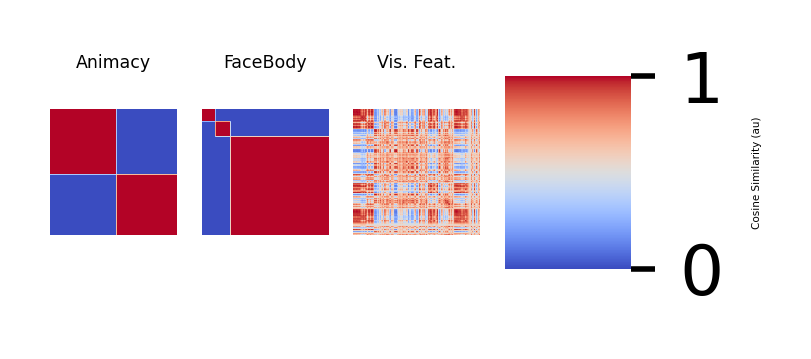

In [6]:
if 1:
    conds = ['Animacy', 'FaceBody', 'Vis. Feat.']

    # RSM for regressors
    rsm_animacy = mk_repmat_kernel([(regressor[:,0]==1).sum(), (regressor[:,0]==0).sum()])
    rsm_fb = mk_repmat_kernel([(regressor[:,1]==1).sum(), (regressor[:,2]==1).sum(), ((regressor[:,1]==0) & (regressor[:,2]==0)).sum()])
    rsm_vis_feat = mk_repmat_data(regressor[:,np.where(feat_df.columns == 'circ')[0][0]:].T, sim_method='cosine')

    plot_repmat([rsm_animacy, rsm_fb, rsm_vis_feat], titles=conds, plot_sz=.5, show_clb=True)
    plt.tight_layout()

    val_anim = rsm_animacy[idx_unique[0],idx_unique[1]]
    val_fb = rsm_fb[idx_unique[0],idx_unique[1]]
    val_vis_feat = rsm_vis_feat[idx_unique[0],idx_unique[1]]

    regressor = np.vstack((val_anim, val_fb, val_vis_feat)).T

    val_itc = rsm_itc[idx_unique[0],idx_unique[1],:]
    val_pfc = rsm_pfc[idx_unique[0],idx_unique[1],:]

    # sub-sampling
    cycle_num = 750
    stim_num = round(vis_feat.shape[0] * .7)
    idx_rand = rand_idx_gen(cycle_num, [np.arange(regressor.shape[0])], stim_num, replacement=False)

    # plt.savefig(f'{FigDir}glm_rsa_repmat.svg')

# GLM

In [40]:
all_beta_itc = np.zeros((regressor.shape[1], cycle_num, time_stamps.shape[0])) * np.nan
all_beta_pfc, all_beta_itc_z, all_beta_pfc_z = np.copy(all_beta_itc), np.copy(all_beta_itc), np.copy(all_beta_itc)

for icycle,tmp_rand in tqdm(enumerate(idx_rand)):
    for itime in range(val_itc.shape[1]):
        tmp_mdl = sm.GLM(val_itc[tmp_rand,itime], sm.add_constant(regressor[tmp_rand])).fit()
        all_beta_itc[:,icycle,itime] = tmp_mdl.params[1:]
        all_beta_itc_z[:,icycle,itime] = tmp_mdl.tvalues[1:]

        tmp_mdl = sm.GLM(val_pfc[tmp_rand,itime], sm.add_constant(regressor[tmp_rand])).fit()
        all_beta_pfc[:,icycle,itime] = tmp_mdl.params[1:]
        all_beta_pfc_z[:,icycle,itime] = tmp_mdl.tvalues[1:]

if 0:
    all_beta_itc, all_beta_pfc = abs(all_beta_itc), abs(all_beta_pfc)
    all_beta_itc_z, all_beta_pfc_z = abs(all_beta_itc_z), abs(all_beta_pfc_z)


0it [00:00, ?it/s]

# Visualization

Text(26.72222222222222, 0.5, 'Beta Value (au)')

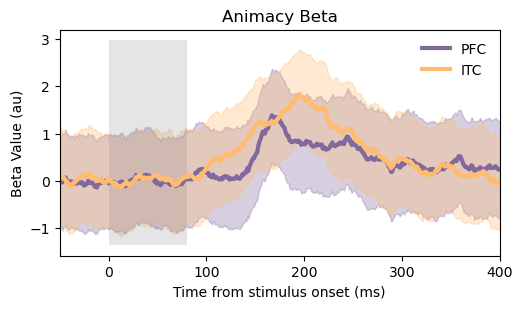

In [41]:
beta_num = 0
smooth_win = 0
fig_sz = np.array((5,3)) * 1
myCond = conds[beta_num].capitalize()
plot_xlim = [-50,400]

if 0:
       beta_select_itc = all_beta_itc[beta_num]
       beta_select_pfc = all_beta_pfc[beta_num]
       plot_ylabel = 'Beta Value (au)'
else:
       beta_select_itc = all_beta_itc_z[beta_num]
       beta_select_pfc = all_beta_pfc_z[beta_num]       
       plot_ylabel = 'Z-Scored Beta Value (au)'

m_plot([beta_select_pfc, beta_select_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=fig_sz)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel(f'Beta Value (au)')

In [42]:
base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peak_raw_itc, onset_raw_itc, sol_raw_itc, _ = FindResp(beta_select_itc, time_stamps, base_time_idx)
_, peak_raw_pfc, onset_raw_pfc, sol_raw_pfc, _ = FindResp(beta_select_pfc, time_stamps, base_time_idx)

if 1:
    idx_non_nan_itc = np.where(~np.isnan(sol_raw_itc))[0][:200]
    idx_non_nan_pfc = np.where(~np.isnan(sol_raw_pfc))[0][:200]

    onset_raw_itc = onset_raw_itc[idx_non_nan_itc]
    peak_raw_itc  = peak_raw_itc[idx_non_nan_itc]
    sol_raw_itc   = sol_raw_itc[idx_non_nan_itc]

    onset_raw_pfc = onset_raw_pfc[idx_non_nan_pfc]
    peak_raw_pfc  = peak_raw_pfc[idx_non_nan_pfc]
    sol_raw_pfc    = sol_raw_pfc[idx_non_nan_pfc]

p_raw_onset = comp_permute_p(onset_raw_itc, onset_raw_pfc)
p_raw_peak  = comp_permute_p(peak_raw_itc, peak_raw_pfc)
p_raw_sol   = comp_permute_p(sol_raw_itc, sol_raw_pfc)


In [43]:
np.random.seed(15)
num_epoch = 200
cycle_num = min((200,idx_non_nan_itc.shape[0]))

beta_plot_itc = beta_select_itc[idx_non_nan_itc]
beta_plot_pfc = beta_select_pfc[idx_non_nan_pfc]

rand_run_itc = np.zeros((num_epoch,time_stamps.shape[0])) * np.nan
rand_run_pfc = np.copy(rand_run_itc)

for i_ep in range(num_epoch):
    tmp_rand_idx = np.random.choice(cycle_num,cycle_num)
    rand_run_itc[i_ep] = np.nanmean(beta_plot_itc[tmp_rand_idx], axis=0)
    rand_run_pfc[i_ep] = np.nanmean(beta_plot_pfc[tmp_rand_idx], axis=0)

base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peak_boot_itc, onset_boot_itc, sol_boot_itc, _ = FindResp(rand_run_itc, time_stamps, base_time_idx)
_, peak_boot_pfc, onset_boot_pfc, sol_boot_pfc, _ = FindResp(rand_run_pfc, time_stamps, base_time_idx)

p_boot_onset = comp_permute_p(onset_boot_itc, onset_boot_pfc)
p_boot_peak  = comp_permute_p(peak_boot_itc, peak_boot_pfc)
p_boot_sol   = comp_permute_p(sol_boot_itc, sol_boot_pfc)


# Face-Body

Onset ITC = 109.1 -+ 20.83290666229751
Onset PFC = 130.075 -+ 24.08109995411339
Onset Permutation p = 1.999960000799984e-05
-----
Peak ITC = 148.77 -+ 21.22680145476468
Peak PFC = 163.13 -+ 4.385555837063302
Peak Permutation p = 1.999960000799984e-05
-----
Solution ITC = 39.67 -+ 25.546058404380116
Solution PFC = 33.055 -+ 24.398196142338065
Solution Permutation p = 0.00881982360352793


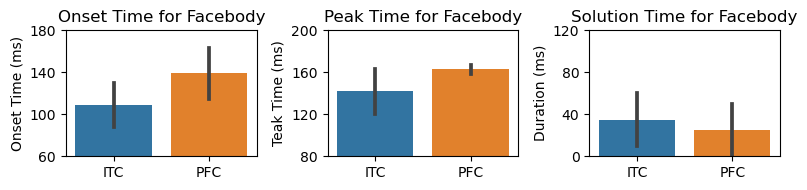

In [35]:
fig_sz = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=fig_sz)
error_method = 'sd'
estimator = 'median'

plt_onset = sns.barplot(ax=ax[0], data=[onset_raw_itc, onset_raw_pfc], estimator=estimator, errorbar=error_method)
ax[0].set_ylim([60,180])
ax[0].set_yticks([60,100,140,180])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=["ITC", "PFC"])

plt_peak = sns.barplot(ax=ax[1], data=[peak_raw_itc, peak_raw_pfc], estimator=estimator, errorbar=error_method)
ax[1].set_ylim([80,200])
ax[1].set_yticks([80,120,160,200])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=["ITC", "PFC"])

plt_sol = sns.barplot(ax=ax[2], data=[sol_raw_itc, sol_raw_pfc], estimator=estimator, errorbar=error_method)
ax[2].set_ylim([0,120])
ax[2].set_yticks([0,40,80,120])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=["ITC", "PFC"])

plt.tight_layout()

print(f'Onset ITC = {np.nanmean(onset_raw_itc)} -+ {np.nanstd(onset_raw_itc)}')
print(f'Onset PFC = {np.nanmean(onset_raw_pfc)} -+ {np.nanstd(onset_raw_pfc)}')
print(f"Onset Permutation p = {p_raw_onset}")
print(f"-----")
print(f'Peak ITC = {np.nanmean(peak_raw_itc)} -+ {np.nanstd(peak_raw_itc)}')
print(f'Peak PFC = {np.nanmean(peak_raw_pfc)} -+ {np.nanstd(peak_raw_pfc)}')
print(f"Peak Permutation p = {p_raw_peak}")
print(f"-----")
print(f'Solution ITC = {np.nanmean(sol_raw_itc)} -+ {np.nanstd(sol_raw_itc)}')
print(f'Solution PFC = {np.nanmean(sol_raw_pfc)} -+ {np.nanstd(sol_raw_pfc)}')
print(f"Solution Permutation p = {p_raw_sol}")

# plt.savefig(f'{FigDir}glmrsa_{myCond}_stat_both.svg')

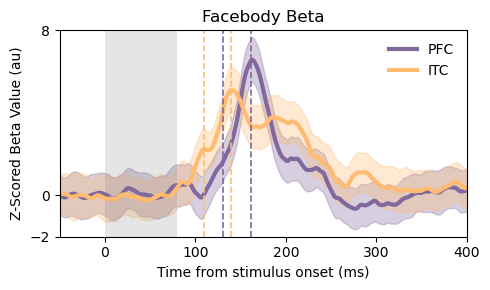

In [37]:
smooth_win = 2
fig_sz = np.array((5,3)) * 1
plot_xlim = [-50,400]
plot_ylim = [-2,8]
time_lw = fig_sz[1]*.4

m_plot([beta_plot_pfc, beta_plot_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=fig_sz)

if 1:
       plt.axvline(np.nanmean(onset_raw_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=time_lw)
       plt.axvline(np.nanmean(onset_raw_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=time_lw)
       plt.axvline(time_stamps[np.nanmean(beta_plot_pfc, axis=0).argmax()], ls='--', color=color_pfc_n[:3], alpha=1, lw=time_lw)
       plt.axvline(time_stamps[np.nanmean(beta_plot_itc, axis=0).argmax()], ls='--', color=color_itc_n[:3], alpha=1, lw=time_lw)
else:
       plt.axvline(np.nanmean(onset_boot_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=time_lw)
       plt.axvline(np.nanmean(onset_boot_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=time_lw)
       plt.axvline(np.nanmean(peak_boot_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=time_lw)
       plt.axvline(np.nanmean(peak_boot_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=time_lw)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel(plot_ylabel)
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0],0,plot_ylim[1]])

plt.tight_layout()
# plt.savefig(f'{FigDir}glmrsa_{myCond}_both.svg')

# Animacy

Onset ITC = 155.705 -+ 57.71549163786097
Onset PFC = 161.95 -+ 56.1286691450991
Onset Permutation p = 0.2773144537109258
-----
Peak ITC = 198.975 -+ 47.11554281763078
Peak PFC = 197.16 -+ 53.88491811258508
Peak Permutation p = 0.7246255074898502
-----
Solution ITC = 43.27 -+ 50.604220179743905
Solution PFC = 35.21 -+ 50.63917357145553
Solution Permutation p = 0.11457770844583108


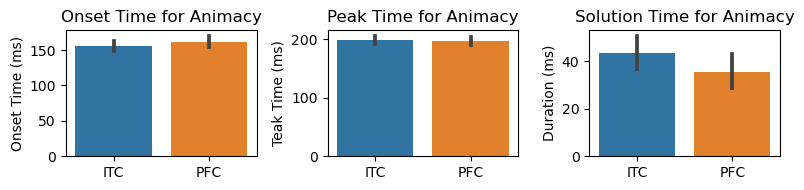

In [44]:
fig_sz = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=fig_sz)
# error_method = 'sd'
error_method = ('ci', 95)
estimator = 'mean'

plt_onset = sns.barplot(ax=ax[0], data=[onset_raw_itc, onset_raw_pfc], estimator=estimator, errorbar=error_method)
# ax[0].set_ylim([80,140])
# ax[0].set_yticks([80,100,120,140])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=["ITC", "PFC"])

plt_peak = sns.barplot(ax=ax[1], data=[peak_raw_itc, peak_raw_pfc], estimator=estimator, errorbar=error_method)
# ax[1].set_ylim([120,180])
# ax[1].set_yticks([120,140,160,180])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=["ITC", "PFC"])

plt_sol = sns.barplot(ax=ax[2], data=[sol_raw_itc, sol_raw_pfc], estimator=estimator, errorbar=error_method)
# ax[2].set_ylim([20,80])
# ax[2].set_yticks([20,40,60,80])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=["ITC", "PFC"])

plt.tight_layout()

print(f'Onset ITC = {np.nanmean(onset_raw_itc)} -+ {np.nanstd(onset_raw_itc)}')
print(f'Onset PFC = {np.nanmean(onset_raw_pfc)} -+ {np.nanstd(onset_raw_pfc)}')
print(f"Onset Permutation p = {p_raw_onset}")
print(f"-----")
print(f'Peak ITC = {np.nanmean(peak_raw_itc)} -+ {np.nanstd(peak_raw_itc)}')
print(f'Peak PFC = {np.nanmean(peak_raw_pfc)} -+ {np.nanstd(peak_raw_pfc)}')
print(f"Peak Permutation p = {p_raw_peak}")
print(f"-----")
print(f'Solution ITC = {np.nanmean(sol_raw_itc)} -+ {np.nanstd(sol_raw_itc)}')
print(f'Solution PFC = {np.nanmean(sol_raw_pfc)} -+ {np.nanstd(sol_raw_pfc)}')
print(f"Solution Permutation p = {p_raw_sol}")

# plt.savefig(f'{FigDir}glmrsa_{myCond}_stat_both.svg')

Onset ITC = 79.78125 -+ 14.61107109138478
Onset PFC = 85.88947368421053 -+ 15.220602199057009
Onset Permutation p = 0.0001399972000559989
-----
Peak ITC = 197.86979166666666 -+ 3.3038367781410183
Peak PFC = 170.46842105263158 -+ 2.2258180356843726
Onset Permutation p = 1.999960000799984e-05
-----
Solution ITC = 118.08854166666667 -+ 14.751323173643234
Solution PFC = 84.57894736842105 -+ 15.587497653648358
Onset Permutation p = 1.999960000799984e-05


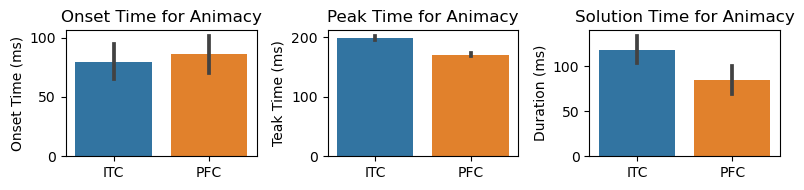

In [12]:
fig_sz = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=fig_sz)
error_method = 'sd'
estimator = 'mean'

plt_onset = sns.barplot(ax=ax[0], data=[onset_boot_itc, onset_boot_pfc], estimator=estimator, errorbar=error_method)
# ax[0].set_ylim([80,140])
# ax[0].set_yticks([80,100,120,140])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=["ITC", "PFC"])

plt_peak = sns.barplot(ax=ax[1], data=[peak_boot_itc, peak_boot_pfc], estimator=estimator, errorbar=error_method)
# ax[1].set_ylim([120,180])
# ax[1].set_yticks([120,140,160,180])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=["ITC", "PFC"])

plt_sol = sns.barplot(ax=ax[2], data=[sol_boot_itc, sol_boot_pfc], estimator=estimator, errorbar=error_method)
# ax[2].set_ylim([20,80])
# ax[2].set_yticks([20,40,60,80])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=["ITC", "PFC"])

plt.tight_layout()

print(f'Onset ITC = {np.nanmean(onset_boot_itc)} -+ {np.nanstd(onset_boot_itc)}')
print(f'Onset PFC = {np.nanmean(onset_boot_pfc)} -+ {np.nanstd(onset_boot_pfc)}')
print(f"Onset Permutation p = {p_boot_onset}")
print(f"-----")
print(f'Peak ITC = {np.nanmean(peak_boot_itc)} -+ {np.nanstd(peak_boot_itc)}')
print(f'Peak PFC = {np.nanmean(peak_boot_pfc)} -+ {np.nanstd(peak_boot_pfc)}')
print(f"Onset Permutation p = {p_boot_peak}")
print(f"-----")
print(f'Solution ITC = {np.nanmean(sol_boot_itc)} -+ {np.nanstd(sol_boot_itc)}')
print(f'Solution PFC = {np.nanmean(sol_boot_pfc)} -+ {np.nanstd(sol_boot_pfc)}')
print(f"Onset Permutation p = {p_boot_sol}")

# plt.savefig(f'{FigDir}glmrsa_{myCond}_stat_both.svg')

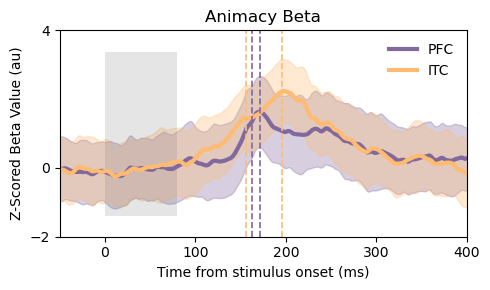

In [14]:
smooth_win = 2
fig_sz = np.array((5,3)) * 1
plot_xlim = [-50,400]
plot_ylim = [-2,4]
time_lw = fig_sz[1]*.4

m_plot([beta_plot_pfc, beta_plot_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=fig_sz)

if 1:
       plt.axvline(np.nanmean(onset_raw_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=time_lw)
       plt.axvline(np.nanmean(onset_raw_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=time_lw)
       plt.axvline(time_stamps[np.nanmean(beta_plot_pfc, axis=0).argmax()], ls='--', color=color_pfc_n[:3], alpha=1, lw=time_lw)
       plt.axvline(time_stamps[np.nanmean(beta_plot_itc, axis=0).argmax()], ls='--', color=color_itc_n[:3], alpha=1, lw=time_lw)
else:
       plt.axvline(np.nanmean(onset_boot_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=time_lw)
       plt.axvline(np.nanmean(onset_boot_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=time_lw)
       plt.axvline(np.nanmean(peak_boot_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=time_lw)
       plt.axvline(np.nanmean(peak_boot_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=time_lw)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel(plot_ylabel)
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0],0,plot_ylim[1]])

plt.tight_layout()
# plt.savefig(f'{FigDir}glmrsa_{myCond}_both.svg')

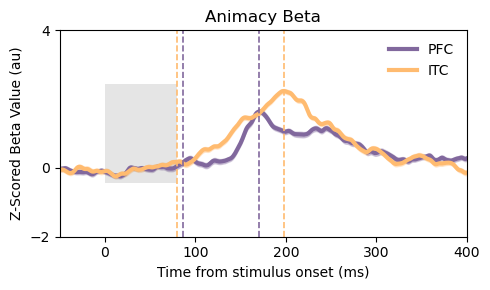

In [15]:
smooth_win = 2
fig_sz = np.array((5,3)) * 1
plot_xlim = [-50,400]
plot_ylim = [-2,4]
time_lw = fig_sz[1]*.4

m_plot([rand_run_pfc, rand_run_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=fig_sz)

plt.axvline(np.nanmean(onset_boot_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=time_lw)
plt.axvline(np.nanmean(onset_boot_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=time_lw)
plt.axvline(np.nanmean(peak_boot_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=time_lw)
plt.axvline(np.nanmean(peak_boot_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=time_lw)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel(plot_ylabel)
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0],0,plot_ylim[1]])

plt.tight_layout()
# plt.savefig(f'{FigDir}glmrsa_{myCond}_both.svg')